### Импорты

In [278]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

# Общая информация о датасете

In [279]:
data = pd.read_excel('AB_Test_Results.xlsx')

data.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [280]:
data.shape

(10000, 3)

In [281]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [282]:
data.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [283]:
data.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [284]:
data.nunique()

USER_ID         6324
VARIANT_NAME       2
REVENUE          101
dtype: int64

In [285]:
data.VARIANT_NAME.unique()

array(['variant', 'control'], dtype=object)

In [286]:
l = data.columns.to_list()
l

['USER_ID', 'VARIANT_NAME', 'REVENUE']

In [287]:
def nunique_colunm(dataset, *columns):
    for i in columns:
        print(f'{dataset[i].value_counts()} \n \n')

nunique_colunm(data, 'USER_ID', 'VARIANT_NAME', 'REVENUE')

5652    6
8359    6
668     6
9101    6
4879    6
       ..
5455    1
1399    1
6967    1
3156    1
9468    1
Name: USER_ID, Length: 6324, dtype: int64 
 

variant    5016
control    4984
Name: VARIANT_NAME, dtype: int64 
 

0.00     9848
1.25       10
1.01        6
3.25        6
0.04        5
         ... 
2.19        1
2.14        1
17.08       1
2.00        1
2.92        1
Name: REVENUE, Length: 101, dtype: int64 
 



In [288]:
data.VARIANT_NAME.value_counts()

variant    5016
control    4984
Name: VARIANT_NAME, dtype: int64

In [289]:
variants = data.groupby('USER_ID', as_index=False).agg({'VARIANT_NAME': pd.Series.nunique})

variants

,USER_ID,VARIANT_NAME
0,2,1
1,3,2
2,4,1
3,5,1
4,6,1
...,...,...
6319,9993,1
6320,9995,1
6321,9996,2
6322,9998,1


In [290]:
variants['VARIANT_NAME'].value_counts()

1    4783
2    1541
Name: VARIANT_NAME, dtype: int64

1541 пользователь попал одновременно и в контрольную, и в тестовую группу. Скорее всего это говорит об ошибках в алгоритме сплитования.

### Чистим датасет

In [291]:
clean_ids = variants.loc[variants['VARIANT_NAME'] == 1]
clean_ids = clean_ids['USER_ID']

In [292]:
clean_data = data[data['USER_ID'].isin(clean_ids)]

clean_data['VARIANT_NAME'].value_counts()

variant    3044
control    3026
Name: VARIANT_NAME, dtype: int64

In [293]:
clean_data.shape

(6070, 3)

In [294]:
clean_data.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
4,6174,variant,0.0
5,2380,variant,0.0
7,9168,control,0.0
9,7548,control,0.0


После очистки выборка сократилась с 10000 пользователей до 6070.

# Проверка данных на нормальность

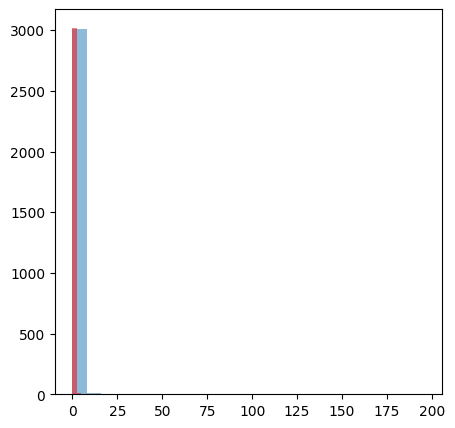

In [295]:
plt.figure(figsize=(5,5))
control = clean_data['REVENUE'][clean_data['VARIANT_NAME'] == 'control']
test = clean_data['REVENUE'][clean_data['VARIANT_NAME'] == 'variant']
plt.hist(control, bins=25, alpha=0.5)
plt.hist(test, bins=10, color='r', alpha=0.5)

plt.show()

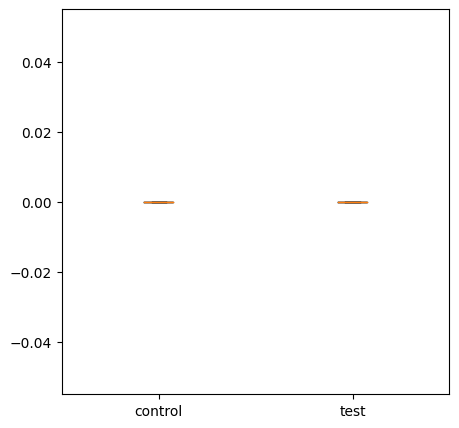

In [296]:
plt.figure(figsize=(5, 5))
plt.boxplot([control, test],labels=['control', 'test'], showfliers=False)

plt.show()

Графические данные показывают, что данные распределены не нормально. Проведем статистические тесты:

In [297]:
from scipy.stats import shapiro
from scipy.stats import kstest

In [298]:
alpha = 0.05

In [299]:
shapiro_pvalue = shapiro(clean_data.REVENUE)[1]

if shapiro_pvalue > alpha:
    print('Распределение нормальное')
else:
    print('Распределение отличное от нормального')

Распределение отличное от нормального


Так как размер выборки более 5000, на всякий случай подтвердим результат тестом Колмагорова-Смирнова.

In [300]:
ks_pvalue = kstest(clean_data.REVENUE, 'norm')[1]

if ks_pvalue > alpha:
    print('Распределение нормальное')
else:
    print('Распределение отличное от нормального')

Распределение отличное от нормального


# Анализ по критерию

1. Количественные данные
2. Выборки независимы
3. Сравниваем 2 группы

__Вывод__: подходит критерий Манна-Уитни

In [301]:
from scipy.stats import mannwhitneyu

In [302]:
control = np.array(clean_data['REVENUE'][data['VARIANT_NAME'] == 'control'])
variant = np.array(clean_data['REVENUE'][data['VARIANT_NAME'] == 'variant'])

In [303]:
mw_pvalue = mannwhitneyu(control, variant)[1]

if mw_pvalue > alpha:
    print('Между группами нет статистически значимых различий')
else:
    print('Между группами есть статистически значимые различия')

Между группами нет статистически значимых различий


# Проверка мощности теста

In [304]:
from statsmodels.stats.power import TTestIndPower

analysis = TTestIndPower()

In [305]:
control_revenue = np.array(clean_data[clean_data['VARIANT_NAME'] == 'control']['REVENUE'])
test_revenue = np.array(clean_data[clean_data['VARIANT_NAME'] == 'variant']['REVENUE'])

In [306]:
control_mean = np.mean(control_revenue)
test_mean = np.mean(test_revenue)

control_sd = np.std(control_revenue)
test_sd = np.std(test_revenue)

In [307]:
effect = (test_mean - control_mean) / np.sqrt((control_sd**2 + test_sd**2) / 2)

In [308]:
l = clean_data[clean_data.VARIANT_NAME == 'control'].shape[0]

In [309]:
power = analysis.solve_power(effect_size=effect,  nobs1=l, ratio=1.0, alpha=0.05)

print(f'Мощность теста равна {int(power * 100)}%')

Мощность теста равна 28%


# Вывод

1. Нужно исправить алгоритмы сплитования, так как большая часть пользоателей попадает одновременно в 2 группы.

2. Маленькая мощность теста, что может говорить о том, что слишком маленькие выборки и тест стоит докрутить (после исправления сплитования).

3. Если оценивать полученные данные, то статистически значимых различий в выборках нет. Следует оставить существующий вариант продукта, чтобы избежать затрат на запуск новой версии.